# Running Portfolio Optimization in Atoti

In this notebook, we demonstrate how we can integrate the output from a portfolio optimizer into Atoti and perform benchmark comparisons.  

We assume that we have received a portfolio with the initial weights for its stocks. Along with the portfolio, we have 3 years worth of data downloaded from [Yahoo Finance](https://finance.yahoo.com/) using [yfinance library](https://pypi.org/project/yfinance/). With iPyWidget, users are able to interactively select the portfolio they want to optimize and load the resultant weights back into Atoti for benchmarking purposes.
We used the Python API [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html) to find the optimal weights for the portfolio stocks.

We can interact with the notebook in two ways:

1. <img src="https://img.shields.io/badge/-Atoti%20CE-%23291A40" /> **Interactively optimize portfolio within the Jupyter Notebook using Atoti and [ipywidget](https://ipywidgets.readthedocs.io/en/stable/).**

    ![https://data.atoti.io/notebooks/cvar-optimisation/img/cvar-jupyter-notebook-2.gif](https://data.atoti.io/notebooks/cvar-optimisation/img/cvar-jupyter-notebook-2.gif)


2. <img src="https://img.shields.io/badge/🔒-Atoti-291A40" /> **Integrated experience of optimizing the portfolio within Atoti web application. *This uses features not part of the Community Edition*.** 

    ![https://data.atoti.io/notebooks/cvar-optimisation/img/cvar-custom-activeui-2.gif](https://data.atoti.io/notebooks/cvar-optimisation/img/cvar-custom-activeui-2.gif)


For option (2), we build a custom widget that allows us to call the Atoti Python endpoint from Atoti UI. This feature is not part of the Community Edition. If you want to see try Atoti Python SDK, you can [register online for an evaluation license](https://atoti.io/evaluation-license-request/) and check out how to [unlock all features of Atoti](https://docs.atoti.io/latest/how_tos/unlock_all_features.html).

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=cvar-optimizer" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
# ! pip install yfinance ipywidgets PyPortfolioOpts

In [2]:
import datetime
import datetime as dt
import functools
import io
import os
import sys
import ipywidgets as widgets
import numpy as np
import pandas as pd
import atoti as tt

from IPython.display import display
from utils import helper
from utils import pyPortfoliOpt as optimizer
from utils import tickers

## 0. Switching between Atoti and Atoti Community Edition 

<img src="https://img.shields.io/badge/-Atoti%20CE-%23291A40" /> 🔛 <img src="https://img.shields.io/badge/🔒-Atoti-291A40" />  

Switch from Atoti Community Edition to Atoti Python SDK by updating the below variable to `True`. 

In [3]:
atoti_unlock = False

By setting the above variable to `True`, we can leverage features not available in the Community Edition to create customized widgets for Atoti UI. Conversely, setting the above variable to `False` will continue to use Atoti Community Edition where no additional licensing setup is required.

💡 **Note:** Want to try Atoti Python SDK? You can [register online for an evaluation license](https://atoti.io/evaluation-license-request/) and check out how to [unlock all features of Atoti](https://docs.atoti.io/latest/how_tos/unlock_all_features.html). 

Below shows the configuration(s) required to register the custom widgets in this use case.

In [4]:
ui_ext = (
    {
        "optimizerwidget-extension": "./ui/packages/optimizerWidget/dist/",
        "uploadwidget-extension": "./ui/packages/uploadWidget/dist/",
    }
    if atoti_unlock
    else {}
)

content = "./content" if atoti_unlock else "./content-atoti-ce"

## 1. Data modeling for portfolio

### 1.1 Create session

Let's instantiate a session with persistent storage to save our dashboards.

In [5]:
session = tt.Session.start(
    tt.SessionConfig(user_content_storage=content, port=12010, app_extensions=ui_ext)
)

### 1.2 Create tables

In this use case, we create the structures of our tables before loading the data.  

In [6]:
portfolio_tbl = session.create_table(
    name="Portfolios Allocation",
    data_types={
        "Portfolio": tt.STRING,
        "Symbols": tt.STRING,
        "Weights": tt.DOUBLE,
        "Iteration": tt.STRING,
        "Opt Method": tt.STRING,
    },
    default_values={"Iteration": "-", "Opt Method": "Base"},
    keys=["Portfolio", "Symbols", "Iteration", "Opt Method"],
)

In [7]:
price_tbl = session.create_table(
    name="Price",
    data_types={
        "Symbols": tt.STRING,
        "Price_Vector": tt.DOUBLE_ARRAY,
        "Daily_Returns_Vector": tt.DOUBLE_ARRAY,
        "Daily_ROR_Vector": tt.DOUBLE_ARRAY,
        "Monthly_ROR_Vector": tt.DOUBLE_ARRAY,
    },
    keys=["Symbols"],
)

In [8]:
dates_tbl = session.create_table(
    name="Historical Dates",
    data_types={
        "Historical Dates": tt.LOCAL_DATE,
        "Date Index": tt.INT,
        "Monthly Date Index": tt.INT,
    },
    keys=["Historical Dates"],
    default_values={"Date Index": -1, "Monthly Date Index": -1},
)

Alternatively, you could use functions such as [`atoti.read_csv`](https://docs.atoti.io/latest/api/atoti.Session.read_csv.html#atoti.Session.read_csv) or [`atoti.read_pandas`](https://docs.atoti.io/latest/api/atoti.Session.read_pandas.html#atoti.Session.read_pandas) to create and load data into table from a data source. For instance, we took a snapshot of the security description from wikipedia and load it into a reference table.

In [9]:
stocks_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/cvar-optimisation/data/constituents.csv",
    table_name="Constituents",
    keys=["Symbols"],
)
stocks_tbl.head(3)

,Security,GICS Sector,GICS Sub-Industry
Symbols,,,
AFL,Aflac,Financials,Life & Health Insurance
AMZN,Amazon,Consumer Discretionary,Internet & Direct Marketing Retail
APH,Amphenol,Information Technology,Electronic Components


### 1.3 Join tables

We enrich the data from the _Portfolios Allocation_ table by joining to some reference table. Atoti assume a join based on the common columns between the two table. Otherwise, we could explicitly define the conditions for the join. Refer to [Atoti documentation](https://docs.atoti.io/latest/index.html) for more examples on [join](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Join).

In [10]:
portfolio_tbl.join(stocks_tbl)
portfolio_tbl.join(price_tbl)
portfolio_tbl.join(dates_tbl)

### 1.4 Create cube  

Below shows how we built an in-memory data cube from the base store `Portfolios Allocation` table. In the [default creation mode](https://docs.atoti.io/latest/api/atoti.Session.create_cube.html#atoti.Session.create_cube), Atoti creates hierarchies from non-numerical and key columns, a mean and sum measure from numerical columns.

In [11]:
cube = session.create_cube(portfolio_tbl, "Portfolio optimization")

As we are dealing with historical data in this use case, we stored the historical values as arrays in the _Price_ table. For each element in the array, we have a corresponding date in the _Historical Dates_ table. We will use the index columns in the _Historical Dates_ to perform the mapping later on.

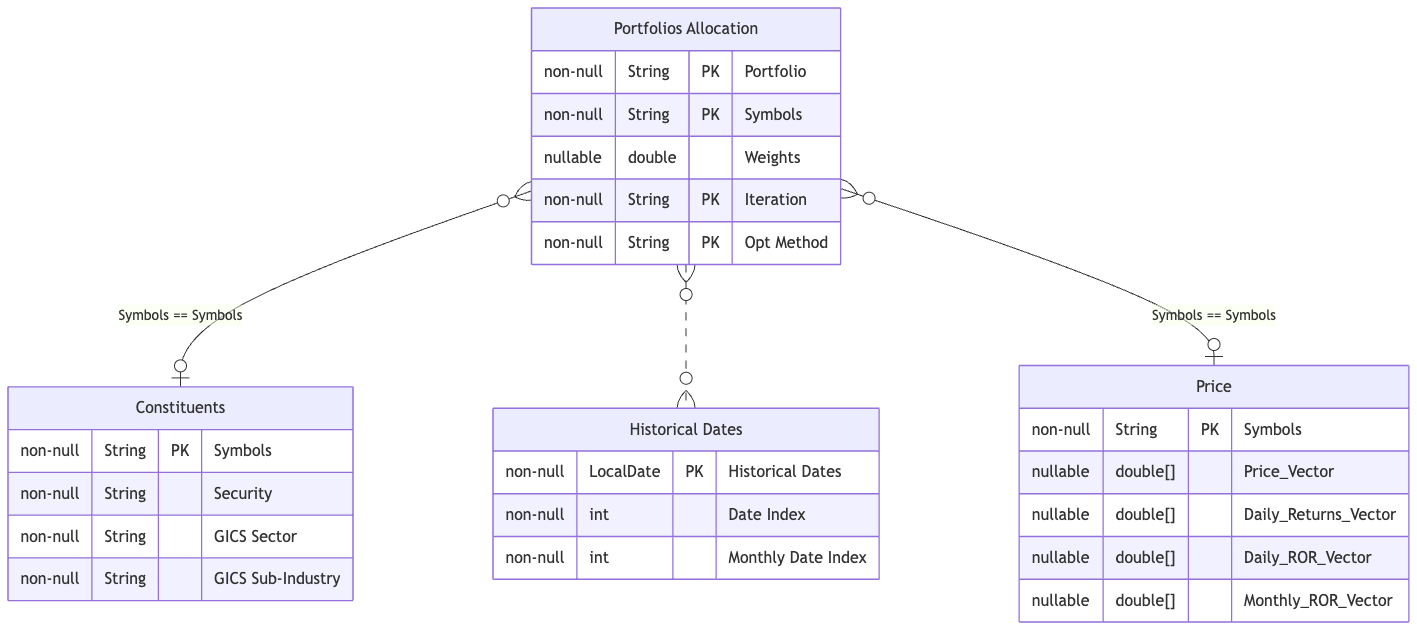

In [12]:
session.tables.schema

## 2. Data Loading

Once the table is created, we can call the table's loading functions to load data for the corresponding data type. In this case, we use `table.load_csv` to load csv data files into the tables.

In [13]:
portfolio_tbl.load(
    tt.CsvLoad(
        "s3://data.atoti.io/notebooks/cvar-optimisation/data/initial_portfolio.csv"
    )
)
price_tbl.load(
    tt.CsvLoad(
        "s3://data.atoti.io/notebooks/cvar-optimisation/data/historical_prices.csv",
        array_separator=",",
    )
)
dates_tbl.load(
    tt.CsvLoad(
        "s3://data.atoti.io/notebooks/cvar-optimisation/data/historical_price_index.csv"
    )
)

## 3. Data exploration with Atoti's JupyterLab extension  

The below code snippet allow us to build visualization in JupyterLab interactively. Use the Atoti extension from the left menu to start exploring the Atoti cube.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
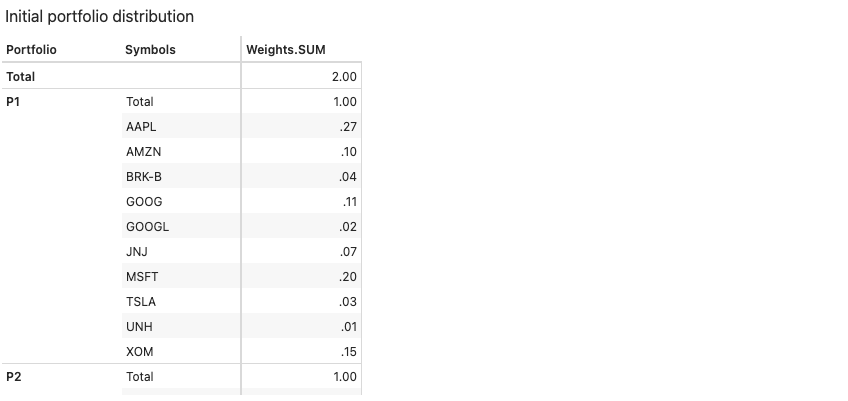

In [14]:
session.widget

## 4. Manipulate hierarchies

### 4.1 Multi-level hierarchies
We could organize our levels into multi-level hierarchies to facilitates the natural order of querying. For instance, when we want to optimize a portfolio, we will want to look into the stocks under the portfolio.

In [15]:
h, l = cube.hierarchies, cube.levels
h["Portfolios"] = [l["Portfolio"], l["Symbols"]]

While this visualization looks similar to the previous one, we are able to expand the portfolio level to investigate the underlying symbols or collapse to focus on the Portfolio, simply by adding the new `Portfolios` hierarchy.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
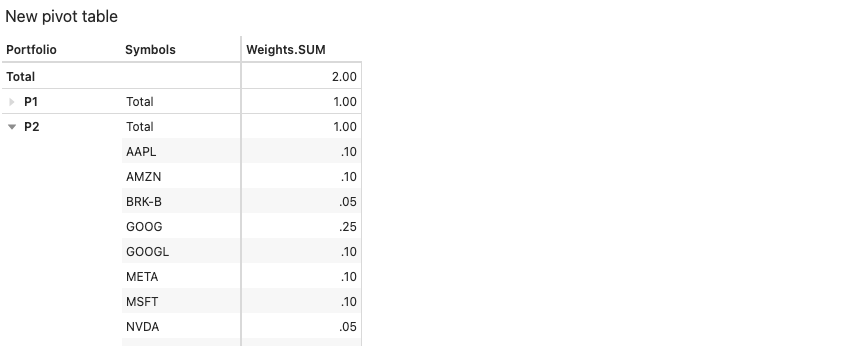

In [16]:
session.widget

Notice that there are two ways to access the below levels now:
- Symbols: (Portfolios Allocation, __Symbols__, Symbols) and (Portfolios Allocation, __Portfolios__, Symbols)
- Portfolio: (Portfolios Allocation, __Portfolio__, Portfolio) and (Portfolios Allocation, __Portfolios__, Portfolio)

We could delete the single-levels hierarchy but it's convenient for us to query them on different axes on certain occasion. So, we will keep them and be mindful of the paths when we construct our measures.

In [17]:
h

{('Constituents', 'GICS Sector'): <atoti.hierarchy.Hierarchy object at 0x11f158990>, ('Constituents', 'GICS Sub-Industry'): <atoti.hierarchy.Hierarchy object at 0x11ef9a710>, ('Constituents', 'Security'): <atoti.hierarchy.Hierarchy object at 0x11f14c610>, ('Portfolios Allocation', 'Portfolio'): <atoti.hierarchy.Hierarchy object at 0x11f131d10>, ('Portfolios Allocation', 'Symbols'): <atoti.hierarchy.Hierarchy object at 0x11f18a3d0>, ('Portfolios Allocation', 'Iteration'): <atoti.hierarchy.Hierarchy object at 0x11f18b010>, ('Portfolios Allocation', 'Opt Method'): <atoti.hierarchy.Hierarchy object at 0x11f18b090>, ('Portfolios Allocation', 'Portfolios'): <atoti.hierarchy.Hierarchy object at 0x11f18b610>, ('Historical Dates', 'Historical Dates'): <atoti.hierarchy.Hierarchy object at 0x11f18a390>}

### 4.2 Slicing

Since we look at the performance of each optimization method separately (i.e. we do not perform aggregation across optimization methods), we can set the hierarchy to [slicing](https://docs.atoti.io/latest/api/atoti.Hierarchy.slicing.html#atoti.Hierarchy.slicing) such that we view the initial portfolio — `Base` by default.

In [18]:
h["Opt Method"].slicing = True

## 5. Create business metrics  

We are going to create some business metrics for our benchmarking purpose, namely:
- VaR
- CVaR
- Sharpe Ratio
- Error Tracking

We will be working a lot with `cube.measures`, so let's alias it to make coding easier.

In [19]:
m = cube.measures

### 5.1 Working with array to compute VaR and CVaR

Atoti has a series of functions that enable us to [work with arrays](https://docs.atoti.io/latest/api/atoti.array.html).  

Since our _Price_ table is a reference table, we will have to create the measures for our arrays. Let's use the [`atoti.agg.single_value`](https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value) to obtain the array for each of the symbols in the portfolio.

In [20]:
m["Daily_Returns_Vector"] = tt.agg.single_value(price_tbl["Daily_Returns_Vector"])
m["Daily_ROR_Vector"] = tt.agg.single_value(price_tbl["Daily_ROR_Vector"])
m["Monthly_ROR_Vector"] = tt.agg.single_value(price_tbl["Monthly_ROR_Vector"])
m["Price_Vector"] = tt.agg.single_value(price_tbl["Price_Vector"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
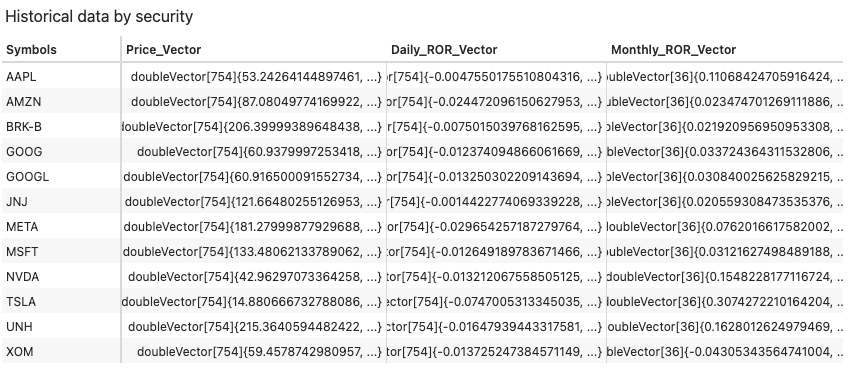

In [21]:
session.widget

#### 5.1.1 Aggregating weighted array

We apply the weights of each stock on their daily returns. Note that we are aggregating from the table and _not_ the measures.

In [22]:
m["Simulated Portfolio Returns Vector"] = tt.agg.sum(
    portfolio_tbl["Weights"] * price_tbl["Daily_ROR_Vector"]
)

By performing a summation on the vector above the _Symbols_ level, we obtained an array containing the daily returns of the portfolio.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
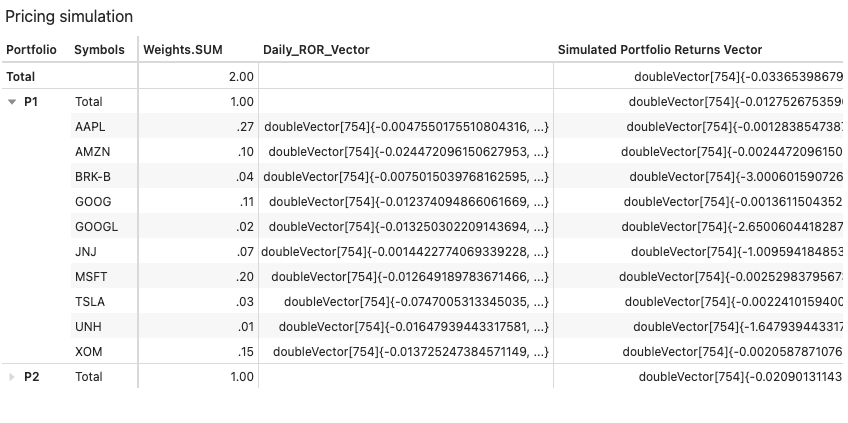

In [23]:
session.widget

#### 5.1.2 Computing VaR with parameter simulation

We could create a measure for `Confidence Level` at 95% simply by:

```python
m["Confidence Level"] = 0.95
```

However, we used the function [`cube.create_parameter_simulation`](https://docs.atoti.io/latest/api/atoti.Cube.create_parameter_simulation.html#atoti.Cube.create_parameter_simulation) to create this measure instead.

In [24]:
confidence_levels = cube.create_parameter_simulation(
    "Confidence Level",
    measures={"Confidence Level": 0.95},
    base_scenario_name="95%",
)

This will allow us to perform simulation on other confidence levels and compare their downstream business metrics accordingly. 

In [25]:
confidence_levels += ("90%", 0.90)
confidence_levels += ("98%", 0.98)

Now, we can use [`atoti.array.quantile`](https://docs.atoti.io/latest/api/atoti.array.quantile.html#atoti.array.quantile) to obtain the greatest loss at 95% confidence level. The below [Atoti quantile function](https://docs.atoti.io/latest/lib/atoti/atoti.array.quantile.html) used the default `PERCENTILE.INC` mode with interpolation set to `lower`. Check out Atoti's documentation to see how you can achieve the standard quantile calculations through different combination of modes and interpolations.

In [26]:
m["VaR"] = tt.array.quantile(
    m["Simulated Portfolio Returns Vector"],
    (1 - m["Confidence Level"]),
    interpolation="lower",
)
m["VaR"].formatter = "DOUBLE[#,##0.000%]"

This demonstrates how Atoti easily achieve non-linear aggregation.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
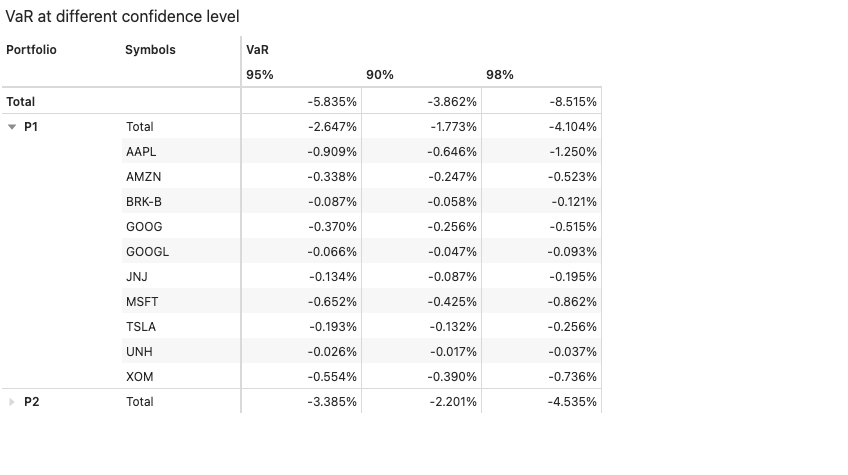

In [27]:
session.widget

#### 5.1.3 Computing CVaR

CVaR, also known as the expected shortfall, is the weighted average of the losses beyond the VaR cutoff point. Therefore, let's get the position of the VaR in the array and compute the CVaR.

In [28]:
m["Number of Tail Exposures"] = tt.math.floor(
    (1 - m["Confidence Level"]) * tt.array.len(m["Simulated Portfolio Returns Vector"])
)
m["CVaR"] = tt.array.mean(
    tt.array.n_lowest(
        m["Simulated Portfolio Returns Vector"], m["Number of Tail Exposures"]
    )
)

m["CVaR"].formatter = "DOUBLE[#,##0.000%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
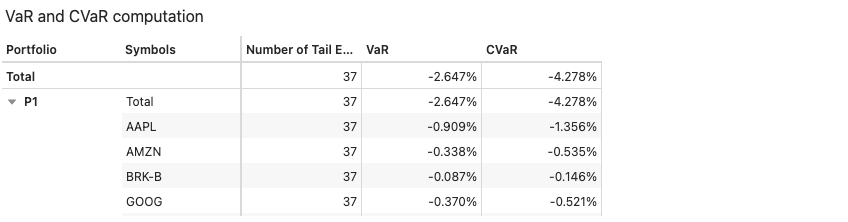

In [29]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
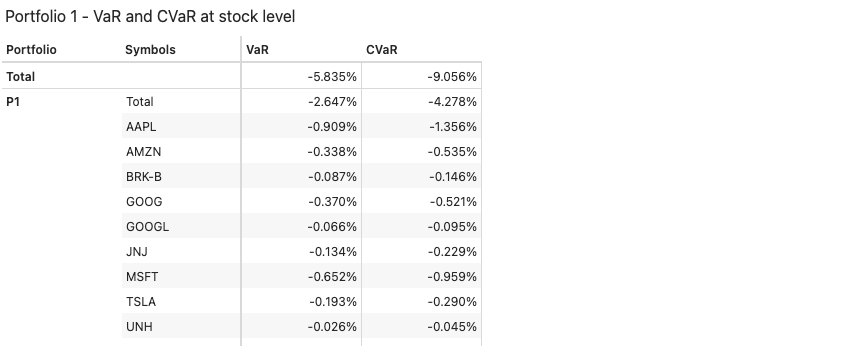

In [30]:
session.widget

#### 5.1.4 Expanding arrays

To query the stocks' values at historical dates level, we need to expand the arrays. We can simply use the `Date Index` and `Monthly Date Index` to return the value at the daily level or monthly level.

In [31]:
# creating measures for the indices
m["Date Index"] = tt.agg.single_value(dates_tbl["Date Index"])

mthly_idx = tt.agg.single_value(dates_tbl["Monthly Date Index"])
m["Monthly Date Index"] = tt.where(mthly_idx != -1, mthly_idx)

# Daily values
m["Daily Price"] = m["Price_Vector"][m["Date Index"]]
m["Daily Price"].formatter = "DOUBLE[#,###.00000]"

m["Daily ROR"] = m["Daily_ROR_Vector"][m["Date Index"]]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

# non-weighted
m["Daily Returns"] = m["Daily_Returns_Vector"][m["Date Index"]]
m["Daily Returns"].formatter = "DOUBLE[#,###.00000]"

# weighted
m["Daily Portfolio Returns"] = m["Simulated Portfolio Returns Vector"][m["Date Index"]]
m["Daily Portfolio Returns"].formatter = "DOUBLE[#,##0.000%]"

# monthly values
m["Monthly ROR"] = m["Monthly_ROR_Vector"][m["Monthly Date Index"]]
m["Monthly ROR"].formatter = "DOUBLE[#,##0.000%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
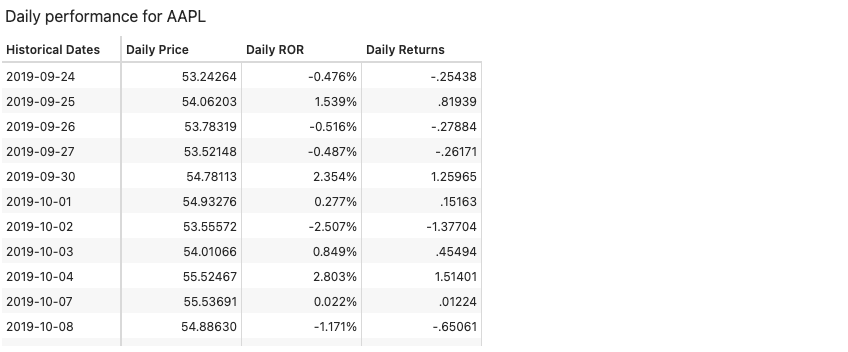

In [32]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
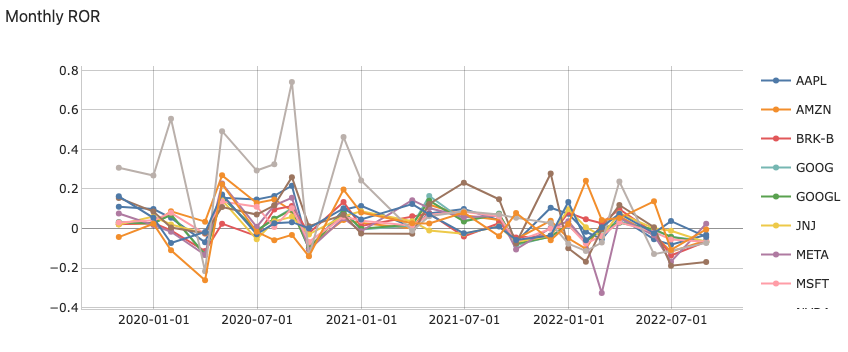

In [33]:
session.widget

#### 5.1.5 Cumulative returns

In [34]:
m["Since Inception ROR"] = (
    tt.agg.prod(
        (m["Daily Portfolio Returns"] + 1),
        scope=tt.CumulativeScope(level=l["Historical Dates"]),
    )
    - 1
)
m["Since Inception ROR"].formatter = "DOUBLE[#,##0.000%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
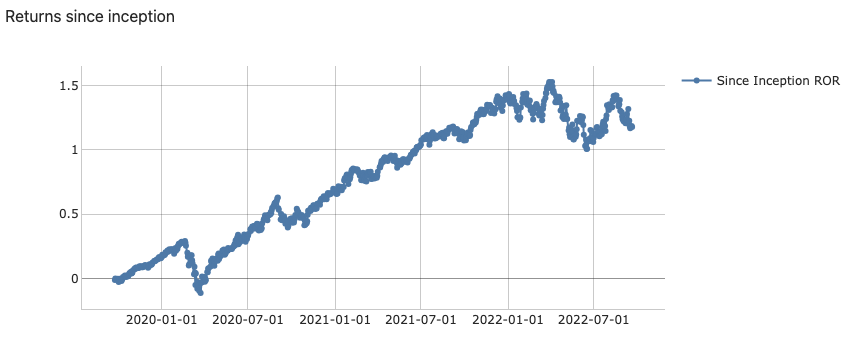

In [35]:
session.widget

### 5.2 Computing Sharpe Ratio

The formula for Sharpe ration is as follows: 

$$Sharpe\ Ratio = {{R_{p} - R_{f}}\over {\sigma_{p}}}$$

Where  
$$R_{p} = Return\ of\ portfolio$$
$$R_{f} = Risk-free\ rate$$
$${\sigma_{p}} = Standard\ deviation\ of\ the\ portfolio's\ excess\ return\ (Volatility) $$

The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance.  

Let's start by assuming the risk-free rate is 0%.

In [36]:
# https://www.mlq.ai/python-for-finance-portfolio-optimization/
m["Mean daily return"] = tt.array.mean(m["Simulated Portfolio Returns Vector"])
m["Mean daily return"].formatter = "DOUBLE[#,###.00000]"

m["Portfolio std"] = tt.array.std(m["Simulated Portfolio Returns Vector"])
m["Portfolio std"].formatter = "DOUBLE[#,###.00000]"

m["Sharpe ratio"] = m["Mean daily return"] / m["Portfolio std"]
m["Sharpe ratio"].formatter = "DOUBLE[#,##0.0000]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
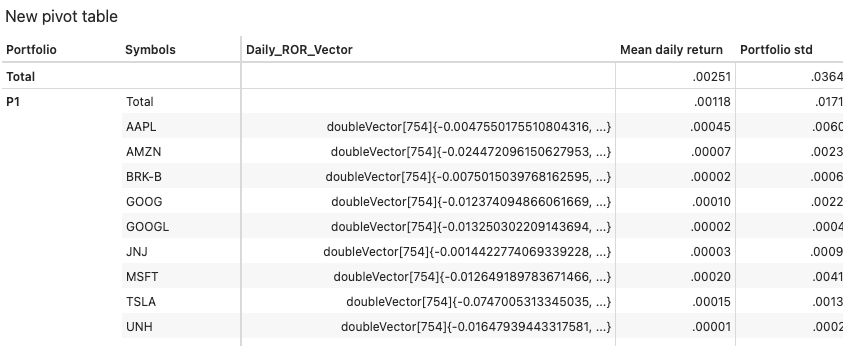

In [37]:
session.widget

Let's create some metrics for benchmarking

In [38]:
m["SR Benchmark"] = tt.at(m["Sharpe ratio"], (l["Opt Method"] == "Base"))
m["SR Opt vs Benchmark"] = m["Sharpe ratio"] - m["SR Benchmark"]

m["SR Benchmark"].formatter = "DOUBLE[#,##0.0000]"
m["SR Opt vs Benchmark"].formatter = "DOUBLE[#,##0.0000]"

### 5.3 Error Tracking

We use the initial portfolio as the benchmark. 

$$Tracking\ Error = {\sigma(P-B)}$$

Where  
P = Daily Portfolio returns  
B = Daily Portfolio returns of benchmark  

💡 **Note:** Portfolio with `Opt Method` equals to `Base` is the benchmark.

In [39]:
m["Benchmark"] = tt.at(
    m["Simulated Portfolio Returns Vector"], (l["Opt Method"] == "Base")
)
m["PnL vs Benchmark"] = m["Simulated Portfolio Returns Vector"] - m["Benchmark"]

m["Error tracking"] = tt.array.std(m["PnL vs Benchmark"], mode="population")

m["PnL vs Benchmark"].formatter = "DOUBLE[#,###.00000]"
m["Benchmark"].formatter = "DOUBLE[#,###.00000]"
m["Error tracking"].formatter = "DOUBLE[#,###.00000]"

There is no data returned as we have yet to perform optimization.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
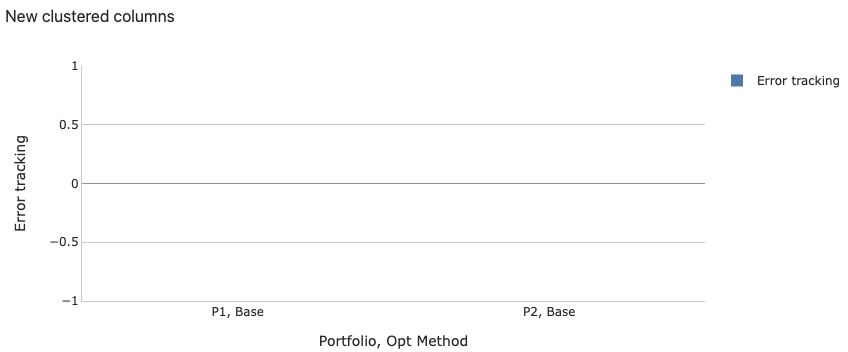

In [40]:
session.widget

## 6. Access BI Web application

Access the below dashboard for Portfolio analysis.

In [41]:
session.link / "#/dashboard/21a"

http://localhost:12010/#/dashboard/21a

Access the below dashboard for benchmarking comparisons.

In [42]:
session.link / "#/dashboard/0c7"

http://localhost:12010/#/dashboard/0c7

## 7. Integrate portfolio optimization 

Atoti is able to integrate with your own optimizer as shown below.  

<img src="https://data.atoti.io/notebooks/cvar-optimisation/img/system_design3.png" width="75%" />

With the Community Edition, we can add interactive components in JupyterLab Using iPyWidgets. This will allow a user to select a portfolio for optimization. After optimization, we can upload the optimized portfolio weights back into Atoti for benchmark comparison via any of the connectors.  

Alternatively, with Atoti Python SDK, we can create custom widgets that allow us to interact with the endpoints, creating a seamless experience within the web application.  

The optimizer we used is [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html). The optimize on different iteration with the followings:

* Minimize the portfolio CVaR (min_cvar_weights).
* Optimize for maximal Sharpe Ratio using the critical line algorithm (max_sharpe).
* Optimize for minimum volatility from the initial weights (min_volatility).
* Hierarchical risk parity ~ hierarchical clustering models (HRPOpt).

In [43]:
helper_util = helper.Helper(session)

In [44]:
out = widgets.Output()


@out.capture()
def optimize_portfolio(b, _portfolio, _iteration):
    b.disabled = True
    _portfolio.disabled = True
    _iteration.disabled = True

    selected_port = _portfolio.value
    iter_token = _iteration.value.split("|")
    print(
        f"Retrieving historical data for portfolio {selected_port} and iteration {_iteration}..."
    )

    helper_util.query_and_optimize(selected_port, iter_token[1], iter_token[0])

    button_refresh = widgets.Button(
        description="Re-select portfolio",
        disabled=False,
        button_style="info",
        tooltip="Re-select portfolio for optimization",
        icon="rotate",
    )

    button_refresh.on_click(display_opt)

    with out:
        display(button_refresh)

In [45]:
def on_portfolio_change(_iteration_dropdown, change):
    opt_mtd = helper_util.get_opt_mtd(change["new"])
    _iteration_dropdown.options = opt_mtd

In [46]:
@out.capture()
def on_upload_change(change):
    input_file = list(change["new"])[0]
    content = input_file["content"]
    df = pd.read_csv(io.BytesIO(content))

    tickers.get_new_tickers(df, session)

In [47]:
def display_opt(_=None):
    out.clear_output()
    portfolio_df = cube.query(
        m["contributors.COUNT"],
        levels=[l[("Portfolios Allocation", "Portfolio", "Portfolio")]],
    )

    portfolio_list = portfolio_df.index.to_list()

    portfolio_dropdown = widgets.Dropdown(
        options=portfolio_list,
        description="Portfolio:",
        disabled=False,
        style={"description_width": "150px"},
    )

    iteration_dropdown = widgets.Dropdown(
        options=helper_util.get_opt_mtd(portfolio_dropdown.value),
        value="-|Base",
        description="Weights from iteration:",
        disabled=False,
        style={"description_width": "150px"},
    )

    opt_button = widgets.Button(
        description="Optimize",
        disabled=False,
        button_style="info",
        tooltip="Optimize selected portfolio",
        icon="gear",
    )

    opt_button.on_click(
        functools.partial(
            optimize_portfolio,
            _portfolio=portfolio_dropdown,
            _iteration=iteration_dropdown,
        )
    )

    uploader = widgets.FileUpload(
        accept=".csv",
        multiple=False,
        tooltip="Upload new portfolio",
    )

    portfolio_dropdown.observe(
        functools.partial(on_portfolio_change, iteration_dropdown),
        names=["value"],
    )

    uploader.observe(on_upload_change, "value")

    hr = widgets.HTML(value="<hr/>")

    with out:
        display(
            widgets.VBox([portfolio_dropdown, iteration_dropdown, opt_button]),
            hr,
            widgets.HBox(
                [widgets.Label(value="Upload new portfolio weights"), uploader]
            ),
        )

In [48]:
display_opt()
out

Output()

## 8. Compare against benchmark

In a quick glance, we can see that the portfolio allocation by `min_cvar` is not well-spread, with all the weights allocated to TSLA.  
We could tackle this problem in many ways. We will leave this problem to the next use case where we set constraints on the optimization to limit such problems. 

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
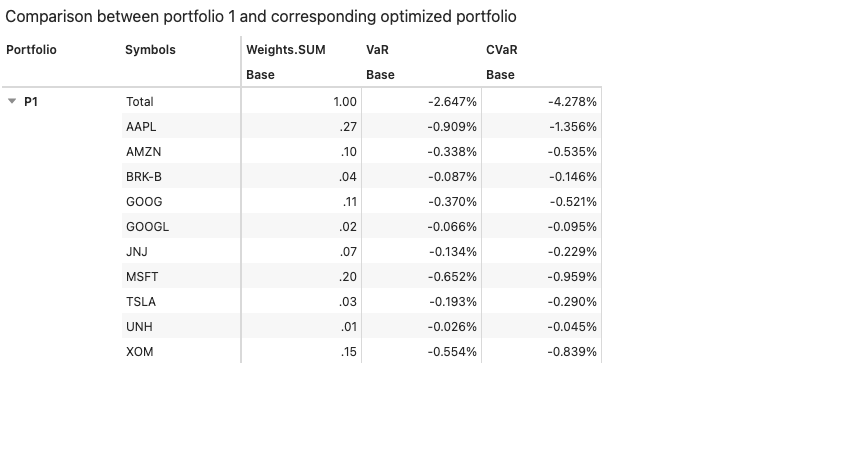

In [49]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
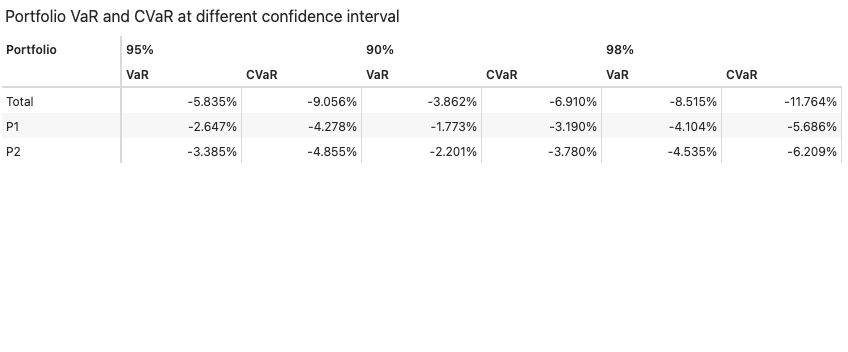

In [50]:
session.widget

For all confidence level, we can see the VaR and cVaR have been reduced significantly from the initial portfolio, particularly where we go for maximum Sharpe Ratio and minimum CVaR. In the chart below, we can shockingly see that `min_cvar` performs really well in terms of the cumulative returns.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
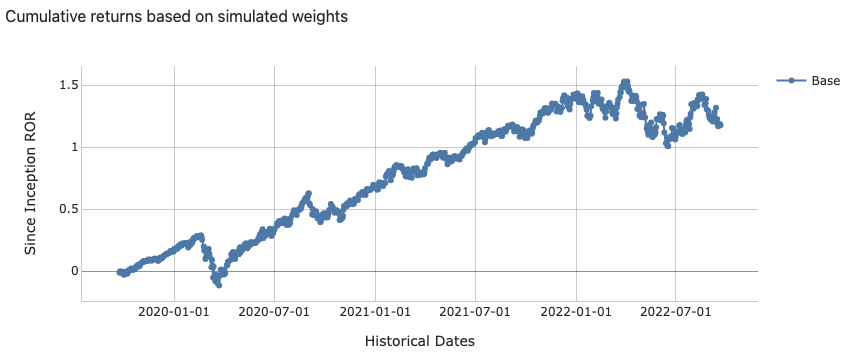

In [51]:
session.widget

However, if we exclude `min_cvar` from the query, we can see that `max_sharpe` also performs very well. `min_volatility` which improves on the initial weights from the portfolio to minimize the volatility has just slightly better returns than the benchmark.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
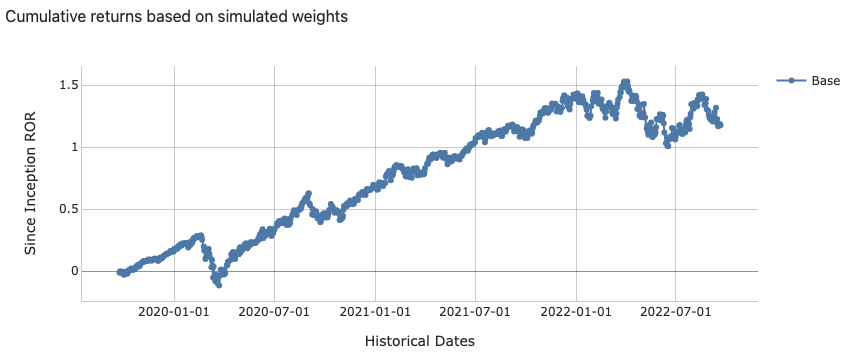

In [52]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
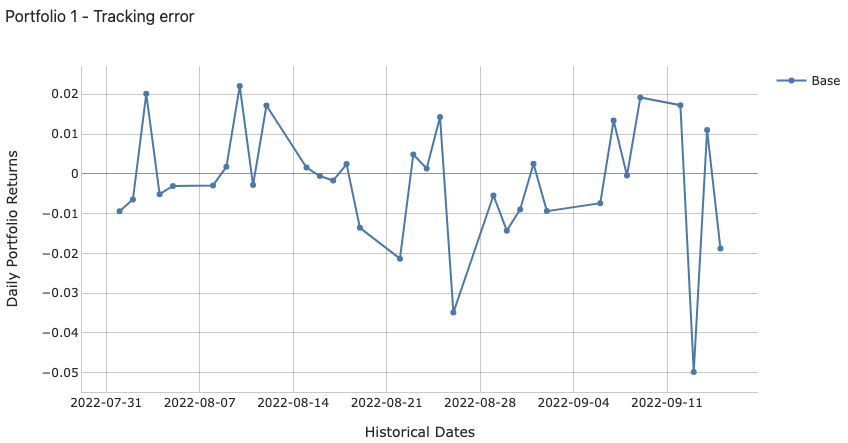

In [53]:
session.widget

The larger the difference between the returns of the benchmark and target, the higher the tracking error. Tracking error does not reflect if it's outperforming or underperforming, but generally, a high tracking error is preferred in the event that there is a certain degree of outperformance. Otherwise, a low tracking error is preferred during consistent underperformance.  

We can see `min_cvar` method has higher fluctuations from the `Base` compared to the other algorithms, therefore a higher tracking error as well.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
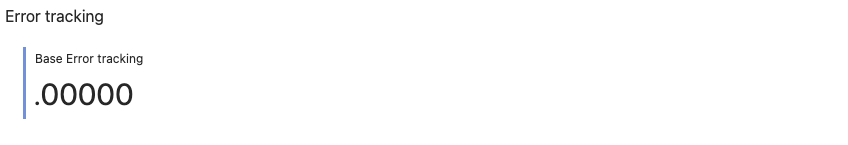

In [54]:
session.widget

The Sharpe ratio compares the return of an investment with its risk. Therefore, a higher Sharpe ratio is better. From the below table, the portfolio weight returned by the `min_cvar` method gives the highest Sharpe ratio. But is it really the best portfolio to have?

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
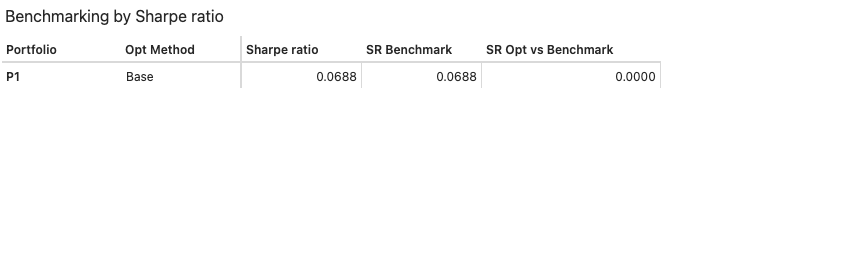

In [55]:
session.widget

## 9. Endpoints for Atoti rest services

Instead of adding a FastAPI or Flask server to the project, we could create [endpoints](https://docs.atoti.io/latest/api/atoti.Session.endpoint.html#atoti.Session.endpoint) to re-use Atoti's built-in server.  

The below endpoints are meant for interaction between the custom UI widgets in the web application and the Atoti server. Remember to run the notebook with `atoti_unlock` set to `True`. 

In [56]:
@session.endpoint("getIteration/{portfolio}", method="GET")
def get_iteration(request, user, session):
    portfolio = request.path_parameters["portfolio"]

    helper_util = helper.Helper(session)
    opt_mtd = helper_util.get_opt_mtd(portfolio)

    return opt_mtd

In [57]:
@session.endpoint("optimize", method="POST")
def trigger_optimization(request, user, session):
    helper_util = helper.Helper(session)
    data = request.body

    selected_port = data["portfolio"]
    selected_method = data["method"]
    selected_iteration = data["iteration"]
    helper_util.query_and_optimize(selected_port, selected_method, selected_iteration)
    return f"hello {selected_port}, {selected_method}, {selected_iteration} "

In [58]:
@session.endpoint("upload/portfolio", method="POST")
def upload_portfolio(request, user, session):
    helper_util = helper.Helper(session)
    data = request.body
    portfolio = data["portfolio"]

    df = pd.DataFrame(data=portfolio[1:], columns=portfolio[0])
    df.dropna(inplace=True)
    df["Weights"] = pd.to_numeric(df["Weights"])
    tickers.get_new_tickers(df, session)

    return "Porfolio(s) uploaded successfully"

Access the web application and have fun. Note that the web application varies between Atoti and the Atoti Community Edition in this use case. You will only be able to access the custom widgets when `atoti_unlock` set to `True`. 

In [59]:
session.link

http://localhost:12010

## Conclusion

Personally speaking, I would go for the optimization by `max_sharpe` as we greatly reduced the VaR and cVaR. It also has one of the better Sharpe Ratio. The portfolio is more balanced compared to the portfolio suggested by `min_cvar`, even though it might reap lesser returns.  

We have demonstrated how we could quickly integrate multiple processes together:

- Streaming of historical data from Yahoo Finance into Atoti.
- Optimization of portfolio using third party optimizer (PyPortfolioOpt in this case).
- Perform benchmarking with interactive dashboards in Atoti.


💡 **Note:** Don't have Atoti license yet? [Request online for a trial license](https://atoti.io/evaluation-license-request/)! Alternatively, reach out to [ActiveViam](https://www.activeviam.com/contact-us/) for a demonstration to see how we integrate the CVaR optimization program into the BI analytics platform! Stay tuned as we explore how we can add constraints to the optimization.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=cvar-optimizer" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>